# Homework

### Dataset

In this homework, we will use Credit Card Data from book "Econometric Analysis".

Here's a wget-able link:
```
wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv
```
The goal of this homework is to inspect the output of different evaluation metrics by creating a classification model (target column card).

### Preparation

* Create the target variable by mapping yes to 1 and no to 0.
* Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split funciton for that with random_state=1.


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
df = pd.read_csv('~/AER_credit_card_data.csv')
df.columns = df.columns.str.lower()

In [4]:
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [5]:
df.card = (df.card == 'yes').astype(int)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   card         1319 non-null   int64  
 1   reports      1319 non-null   int64  
 2   age          1319 non-null   float64
 3   income       1319 non-null   float64
 4   share        1319 non-null   float64
 5   expenditure  1319 non-null   float64
 6   owner        1319 non-null   object 
 7   selfemp      1319 non-null   object 
 8   dependents   1319 non-null   int64  
 9   months       1319 non-null   int64  
 10  majorcards   1319 non-null   int64  
 11  active       1319 non-null   int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 123.8+ KB


In [7]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.card.values
y_val = df_val.card.values
y_test = df_test.card.values

del df_train['card']
del df_val['card']
del df_test['card']

### Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

* For each numerical variable, use it as score and compute AUC with the card variable.
* Use the training dataset for that.

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['expenditure'])

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

* reports
* dependents
* active
* share

In [8]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [9]:
numerical = ['reports', 'age', 'income', 'share', 'expenditure', 'dependents', 'months', 'majorcards', 'active']

categorical = ['owner', 'selfemp']

In [10]:
for c in numerical:
    auc = roc_auc_score(y_train, df_train[c])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[c])
    print('%9s, %.3f' % (c, auc))

  reports, 0.717
      age, 0.524
   income, 0.591
    share, 0.989
expenditure, 0.991
dependents, 0.533
   months, 0.529
majorcards, 0.534
   active, 0.604


### Training the model

From now on, use these columns only:
```
["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]
```
Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [11]:
dv = DictVectorizer(sparse=False)

columns = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", 
           "active", "owner", "selfemp"]

train_dict = df_train[columns].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [12]:
val_dict = df_val[columns].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
card_decision = (y_pred >= 0.5)
(y_val == card_decision).mean()

0.9696969696969697

### Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

* 0.615
* 0.515
* 0.715
* 0.995


In [13]:
roc_auc_score(y_val, y_pred)

0.995171242063847

In [14]:
len(y_val)

264

In [15]:
(y_val == card_decision).mean()

0.9696969696969697

In [16]:
from sklearn.metrics import accuracy_score

In [17]:
accuracy_score(y_val, y_pred >= 0.5)

0.9696969696969697

In [18]:
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.799
0.05 0.917
0.10 0.932
0.15 0.955
0.20 0.966
0.25 0.962
0.30 0.958
0.35 0.973
0.40 0.973
0.45 0.970
0.50 0.970
0.55 0.970
0.60 0.970
0.65 0.970
0.70 0.970
0.75 0.970
0.80 0.970
0.85 0.973
0.90 0.973
0.95 0.973
1.00 0.879


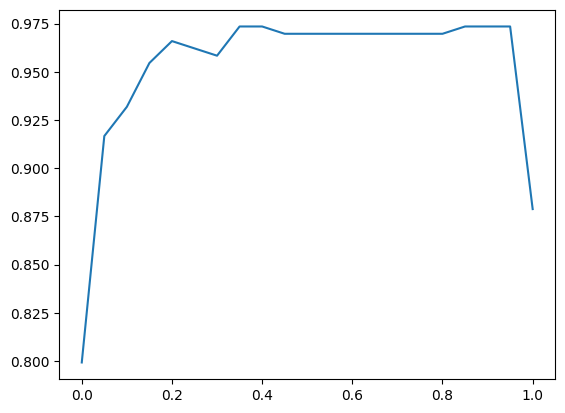

In [19]:
plt.plot(thresholds, scores)

In [20]:
val_dict = df_val[columns].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred_probs = model.predict_proba(X_val)[:, 1]
'''
The following line is not needed
You calculate the AUC using the probabilities, not comparing the binary classifications.
'''
#y_pred = (y_pred_probs >= 0.5)

#y_pred_direct = model.predict(X_val)

print('AUC using probs: ', roc_auc_score(y_val, y_pred_probs).round(3))
#print('AUC with straight prediction: ', roc_auc_score(y_val, y_pred_direct).round(3))

AUC using probs:  0.995


### Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on the validation dataset on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.1
* 0.3
* 0.6
* 0.8

In [21]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred_probs >= t)
    predict_negative = (y_pred_probs < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    scores.append((t, tp, fp, fn, tn, precision, recall))

In [22]:
score_columns = ['threshold', 'tp', 'fp', 'fn', 'tn', 'precision', 'recall']
df_scores = pd.DataFrame(scores, columns=score_columns)

In [23]:
df_scores[::10]

,threshold,tp,fp,fn,tn,precision,recall
0,0.0,211,53,0,0,0.799242,1.000000
10,0.1,210,17,1,36,0.925110,0.995261
20,0.2,207,5,4,48,0.976415,0.981043
30,0.3,205,5,6,48,0.976190,0.971564
40,0.4,205,1,6,52,0.995146,0.971564
50,0.5,204,1,7,52,0.995122,0.966825
60,0.6,204,1,7,52,0.995122,0.966825
70,0.7,204,1,7,52,0.995122,0.966825
80,0.8,204,1,7,52,0.995122,0.966825
90,0.9,204,0,7,53,1.000000,0.966825


In [24]:
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

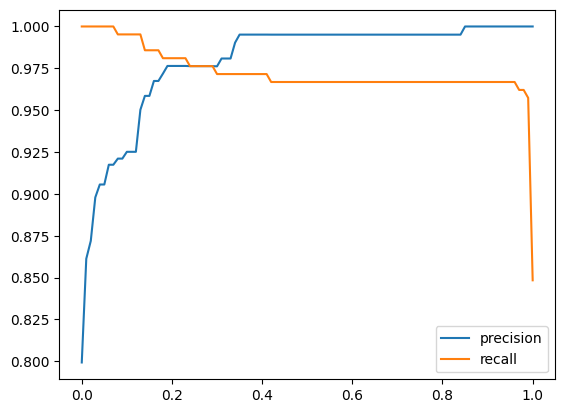

In [25]:
plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')

plt.legend()

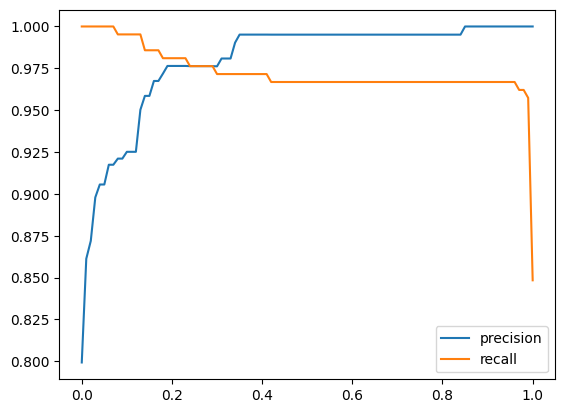

In [26]:
plt.plot(df_scores.threshold, df_scores['precision'], label='precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='recall')
plt.legend()

### Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing :

 * F1 = 2 (P x R) / (P + R)

Where  is precision and  is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01 using the validation set

At which threshold F1 is maximal?

* 0.1
* 0.4
* 0.6
* 0.7

In [27]:
df_scores['f1'] = 2 * ( (df_scores.precision * df_scores.recall) / (df_scores.precision + df_scores.recall) )

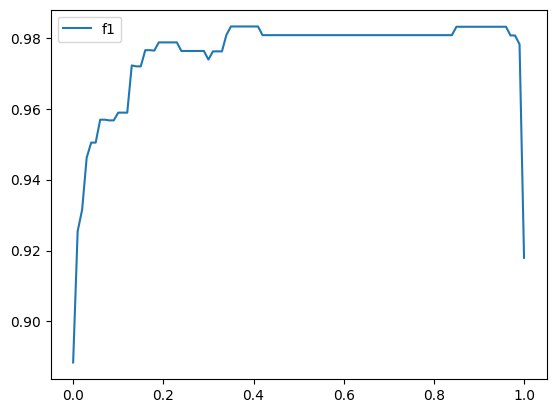

In [28]:
plt.plot(df_scores.threshold, df_scores.f1, label='f1')
plt.legend()

In [29]:
df_scores[df_scores['f1'] == df_scores['f1'].max()]

,threshold,tp,fp,fn,tn,precision,recall,p,r,f1
35,0.35,205,1,6,52,0.995146,0.971564,0.995146,0.971564,0.983213
36,0.36,205,1,6,52,0.995146,0.971564,0.995146,0.971564,0.983213
37,0.37,205,1,6,52,0.995146,0.971564,0.995146,0.971564,0.983213
38,0.38,205,1,6,52,0.995146,0.971564,0.995146,0.971564,0.983213
39,0.39,205,1,6,52,0.995146,0.971564,0.995146,0.971564,0.983213
40,0.40,205,1,6,52,0.995146,0.971564,0.995146,0.971564,0.983213
41,0.41,205,1,6,52,0.995146,0.971564,0.995146,0.971564,0.983213


### Question 5

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:
```
KFold(n_splits=5, shuffle=True, random_state=1)
```
* Iterate over different folds of df_full_train
* Split the data into train and validation
* Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
* Use AUC to evaluate the model on validation

How large is standard devidation of the AUC scores across different folds?

* 0.003
* 0.014
* 0.09
* 0.24

In [30]:
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

/Users/giovanni/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [31]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[columns].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    dicts = df[columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [32]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

kscores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train['card'].values
    y_val = df_val['card'].values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    kscores.append(auc)

print(f'Mean: {np.mean(kscores)}, Standard deviation: {np.std(kscores)}')

Mean: 0.9964498276814243, Standard deviation: 0.0027434713804377724


In [33]:
scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.card.values
    y_val = df_val.card.values

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.996 +- 0.003


### Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: [0.01, 0.1, 1, 10]
* Initialize KFold with the same parameters as previously
* Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?

* 0.01
* 0.1
* 1
* 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C



In [34]:
for C in tqdm([0.01, 0.1, 1, 10]):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    kscores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        f_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train['card'].values
        y_val = df_val['card'].values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        kscores.append(auc)

    print(f'C: {C}, Mean: {np.mean(kscores).round(3)}, Standard deviation: {np.std(kscores).round(3)}')

 25%|███████████▎                                 | 1/4 [00:00<00:00,  7.62it/s]

C: 0.01, Mean: 0.993, Standard deviation: 0.005


 50%|██████████████████████▌                      | 2/4 [00:00<00:00,  7.75it/s]

C: 0.1, Mean: 0.997, Standard deviation: 0.003


 75%|█████████████████████████████████▊           | 3/4 [00:00<00:00,  7.67it/s]

C: 1, Mean: 0.997, Standard deviation: 0.002


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  7.59it/s]

C: 10, Mean: 0.997, Standard deviation: 0.002
